In [ ]:
!pip install salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 30.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/images-last.zip', '/content/imagesnew.zip')

'/content/imagesnew.zip'

In [ ]:
!apt-get install p7zip-full
!7z x /content/imagesnew.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4985639110 bytes (4755 MiB)

Extracting archive: /content/imagesnew.zip
  8% 256 Open              25% 768 Open              42% 1280 Open               59% 1792 Open               76% 2304 Open              
ERRORS:
Headers Error

--
Path = /content/imagesnew.zip
Type = zip
ERRORS:
Headers Error
Physical Size = 4985639110
64-bit

In [ ]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model, vis_processors, text_processors = load_model_and_preprocess("blip2_image_text_matching", "pretrain", device=device, is_eval=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.89G/1.89G [00:16<00:00, 124MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 712M/712M [00:02<00:00, 256MB/s]


In [ ]:
import pandas as pd
df = pd.read_csv("/content/emnlp3000.csv")
llm_prompts = []
for i in range(len(df)):
  a =  df["our_summary"][i]
  llm_prompts.append(a)


In [ ]:
from PIL import Image
import os
images_llm_prompt =[]
a="/content/images"

for i in range(len(os.listdir(a))):
  b=a+'/sd_n_'+str(i)+'.png'
  image = Image.open(b)
  images_llm_prompt.append(image)


In [ ]:
llm_prompts[12]

'The poem tells the story of a lost elephant who mistakenly ends up in England. Despite the confusion, he eventually finds his way back to Africa.'

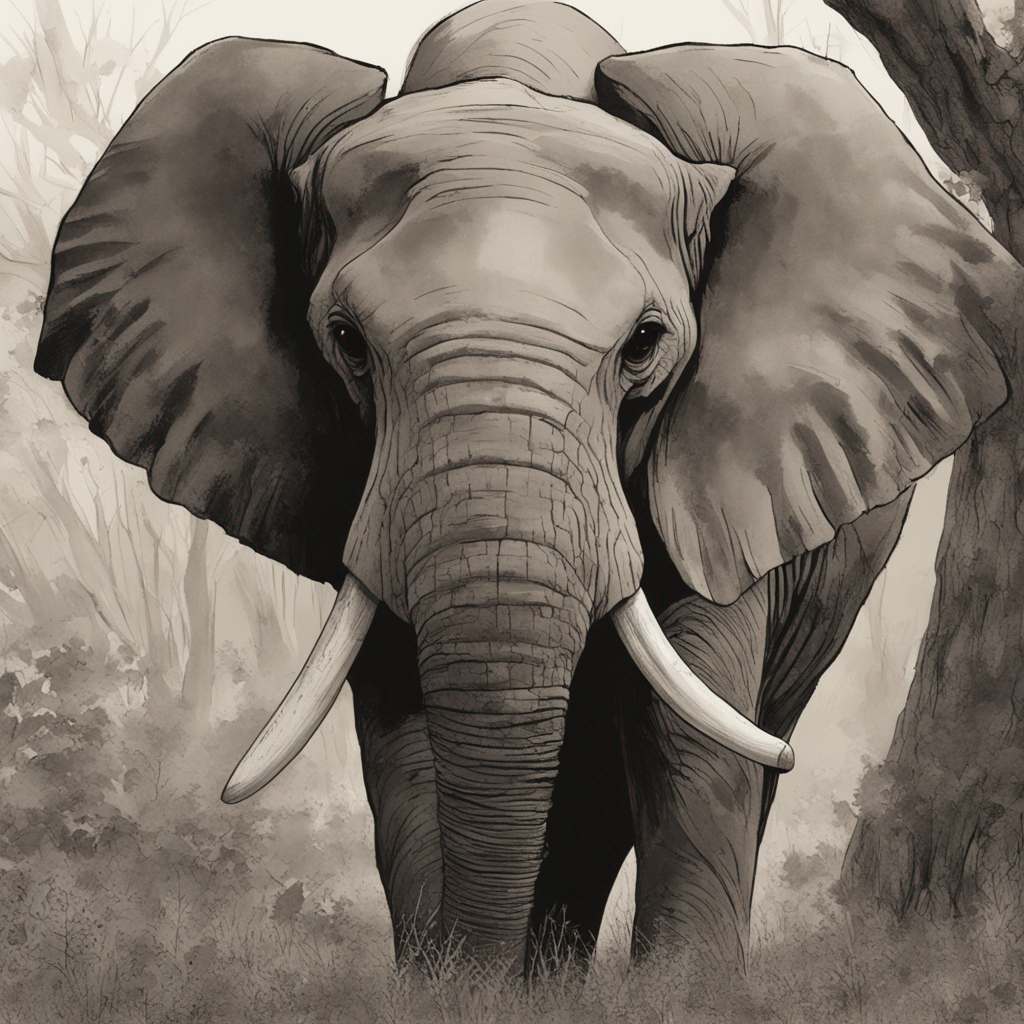

In [ ]:
images_llm_prompt[12]

In [ ]:
avg_itm = 0
avg_itc = 0
for i in range(0, len(llm_prompts), 10):
  imgs = [vis_processors["eval"](image).unsqueeze(0).to(device) for image in images_llm_prompt[i: i + 10]]
  txts = [text_processors["eval"](prompt) for prompt in llm_prompts[i: i + 10]]

  itm_outputs = [model({"image": img, "text_input": txt}, match_head="itm") for img, txt in zip(imgs, txts)]
  itm_scores = [torch.nn.functional.softmax(itm_output, dim=1) for itm_output in itm_outputs]
  itc_scores = [model({"image": img, "text_input": txt}, match_head="itc") for img, txt in zip(imgs, txts)]

  avg_itm += sum([itm_scores[i][:, 1].item() for i in range(len(itm_scores))])
  avg_itc += sum([itc_scores[i].item() for i in range(len(itm_scores))])

avg_itm /= len(llm_prompts)
avg_itc /= len(llm_prompts)

In [ ]:
print(avg_itm)
print(avg_itc)

In [ ]:
import csv

rows = []
rows.append(['Prompts', 'ITM score', 'Cosine Similarity'])
for i in range(len(llm_prompts)):
  rows.append([llm_prompts[i], itm_scores[i][:, 1].item(), itc_scores[i].item()])

with open('results.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows(rows)

In [ ]:
!pip install torch-fidelity

In [ ]:
!fidelity --gpu 0 --isc --input1 /content/playgroundimages

2024-02-11 12:13:21.139883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 12:13:21.139948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 12:13:21.141181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 12:13:22.370739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/content/playgroundimages" with extensions png,jpg,jpeg
Found 3011 samples
/usr/local